# Processing of Slocum Glider-AD2CP Data: RU29 2021 Mission 1

jgradone@marine.rutgers.edu     03/10/2022    Initial

**This Jupyter Notebook is intended to:**<br>
1) Read glider data frome ERDDAP <br>
2) Read in AD2CP data processed to NetCDFs using the Nortek MIDAS software as an xarray DataSet and combine all into one massive DataSet <br>

**Then in a big for loop:** <br>
3) Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data <br>
4) Correct for local speed of sound <br>
5) QAQC AD2CP data <br>
6) Correct beams to level true-depth <br>
7) Bin map AD2CP data <br>
8) AD2CP Coordinate transformation from beam to XYZ to ENU <br>
9) Least squares linear inversion on ADCP velocities referenced to true ocean velocity through a depth averaged urrent constraint <br>
10) Save output from each segment<br>

*Details/comments on what the functions are actually doing in the source code*

In [1]:
# Imports
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys
from datetime import datetime


## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/data/')
from make_dataset import correct_sound_speed, beam_true_depth, cell_vert, binmap_adcp, beam2enu, inversion_new, inversion, qaqc_pre_coord_transform
from analysis import get_erddap_dataset



## Step 1: Load glider data

In [2]:
ds_id = 'ru29-20210630T1343-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf

,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.000000,18.170740,-64.831853,2021-06-30T13:43:52Z,0.0000,0.00000,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
1,NaN,18.170740,-64.831853,2021-06-30T13:43:57Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),-0.100307,0.03465,2.53247
2,0.000000,18.170740,-64.831853,2021-06-30T13:43:57Z,0.0000,0.00000,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
3,NaN,18.170740,-64.831853,2021-06-30T13:44:54Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),-0.100307,0.03465,2.53247
4,NaN,18.170465,-64.834150,2021-06-30T13:45:20Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
732984,0.238559,18.164417,-63.468548,2021-07-12T12:53:52Z,28.1624,5.63906,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732985,0.198799,18.164417,-63.468548,2021-07-12T12:53:54Z,28.1629,5.63894,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732986,0.178920,18.164417,-63.468548,2021-07-12T12:53:56Z,28.1619,5.63898,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732987,0.198799,18.164417,-63.468548,2021-07-12T12:53:58Z,28.1565,5.63899,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN


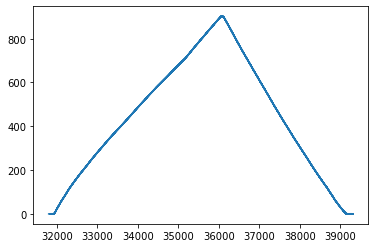

In [3]:
x=10
plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

## Step 2: Load in AD2CP data frame

In [4]:
path = '/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/'
files = np.sort(glob.glob(path+'*.nc'))

tot_ad2cp = xr.open_mfdataset(files,group='Data/Burst/', concat_dim="time", combine="nested")
## I think this is a documented bug in the xarray open_mfdataset function for grouped NetCDFs
config = xr.open_dataset(files[0],group='Config')
## So, just assigning the global attributes from the first file to the combined file
tot_ad2cp = tot_ad2cp.assign_attrs(config.attrs)
tot_ad2cp = tot_ad2cp.rename({'Velocity Range':'VelocityRange','Correlation Range':'CorrelationRange','Amplitude Range':'AmplitudeRange'})
# 2 House-keeping steps
# 1) Roll shifted 180 for some reason
tot_ad2cp['Roll'] = tot_ad2cp['Roll']-180
# 2) Surface depth is 10 meters. Needed for at least for the 2020 and both 2021 deployments, per conversations with Sven from Nortek.
tot_ad2cp['Pressure'] = tot_ad2cp['Pressure']-10
# Put time on x-dimension
tot_ad2cp = tot_ad2cp.transpose()
tot_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 3752193, VelocityRange: 40, CorrelationRange: 40, AmplitudeRange: 40, Physicalbeam_dim: 4, AHRSRotationMatrix_dim: 9)
Coordinates:
  * time                       (time) datetime64[ns] 2021-07-09T01:36:06.9070...
  * VelocityRange              (VelocityRange) float32 0.7 1.2 1.7 ... 19.7 20.2
  * CorrelationRange           (CorrelationRange) float32 0.7 1.2 ... 19.7 20.2
  * AmplitudeRange             (AmplitudeRange) float32 0.7 1.2 ... 19.7 20.2
Dimensions without coordinates: Physicalbeam_dim, AHRSRotationMatrix_dim
Data variables: (12/52)
    VelocityBeam1              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    VelocityBeam2              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    VelocityBeam3              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    VelocityBeam4              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    ...                         ...
    QuaternionX                (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    QuaternionY                (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    QuaternionZ                (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    AHRSGyroX                  (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    AHRSGyroY                  (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    AHRSGyroZ                  (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
Attributes: (12/350)
    exportRevision:                               4421
    File_ins_runTime:                             96653500.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -18000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

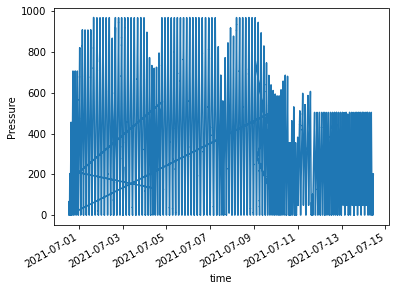

In [5]:
tot_ad2cp.Pressure.plot()

## Steps 3-10: Big loop to process velocity data and save output

In [ ]:
for x in np.arange(0,len(start_times)):

## Restarting because it stopped at 154 for some reason.
## Checked 156 and it processed fine before but now keeps crashing the kernel...
#for x in np.arange(157,len(start_times)):


    ## Subset glider df to one segment
    subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
    ## Pull out last non-NaN DAC
    ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
    vx          = subsetgdf.m_water_vx.iloc[ind[-1]]
    vy          = subsetgdf.m_water_vy.iloc[ind[-1]]
    
    ## Pull out last non-NaN lat/lon
    ind1         = np.argwhere(np.isnan(subsetgdf.longitude).ravel()==False).flatten()   
    vx_start_lon = subsetgdf.longitude.iloc[ind1[0]]
    vx_start_lat = subsetgdf.latitude.iloc[ind1[0]]
    vx_end_lon   = subsetgdf.longitude.iloc[ind1[-1]]
    vx_end_lat   = subsetgdf.latitude.iloc[ind1[-1]]
    ## Not using the index here because I want the segment start and end times
    vx_start_tm  = subsetgdf.time.iloc[0]
    vx_end_tm    = subsetgdf.time.iloc[-1]

    ## Check is glider has a max depth greater than 10 meters. If not, continue to next segment.
    ## This is needed because the glider opens and closes a log file at the surface while sending data and
    ## so indexing by unique file names gives a segment with just surface data (which we don't want).
    if subsetgdf.depth.max() < 10:
        continue
    
    ## Subset AD2CP dataframe based on segment start and end times
    ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
    subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time.values[ad2cp_time_ind])
    
    ## Just check if there is still data after the subsetting 
    if len(subset_ad2cp.time) > 0:
        ## Now process AD2CP!

        ## Correct for local speed of sound
        subset_ad2cp = correct_sound_speed(subset_ad2cp)
        now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
        print("Finished Sound Speed Correction", x ,"out of",len(start_times),"at" ,now)

        ## QAQC pre-coordinate transformation
        subset_ad2cp = qaqc_pre_coord_transform(subset_ad2cp)
        now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
        print("Finished QAQC", x ,"out of",len(start_times),"at" ,now)

        ## Correct beams to level true-depth
        subset_ad2cp = beam_true_depth(subset_ad2cp)
        now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
        print("Finished Beam to True Depth", x ,"out of",len(start_times),"at" ,now)

        ## Bin map
        subset_ad2cp = binmap_adcp(subset_ad2cp)
        now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
        print("Finished Bin Mapping", x ,"out of",len(start_times),"at" ,now)

        ## Beam to ENU
        subset_ad2cp = beam2enu(subset_ad2cp)
        now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
        print("Finished Beam to ENU", x ,"out of",len(start_times),"at" ,now)

        ## Filter out really high velocities relative to glider
        subset_ad2cp.UVelocity.values[subset_ad2cp.UVelocity>0.5] = np.NaN
        subset_ad2cp.VVelocity.values[subset_ad2cp.VVelocity>0.5] = np.NaN
        subset_ad2cp.WVelocity.values[subset_ad2cp.WVelocity>0.5] = np.NaN
        now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
        print("Finished Filtering High Velocities", x ,"out of",len(start_times),"at" ,now)

        ## Now ready for inversion!
        #O_ls, G_ls, bin_new = inversion(U=subset_ad2cp.UVelocity.transpose().values,V=subset_ad2cp.VVelocity.transpose().values,H=1000,dz=5,u_daverage=vx,v_daverage=vy,bins = subset_ad2cp['VelocityRange'], depth = subset_ad2cp['Pressure'])
        O_ls, G_ls, bin_new = inversion_new(U=subset_ad2cp.UVelocity.values,V=subset_ad2cp.VVelocity.values,dz=10,u_daverage=vx,v_daverage=vy,bins = subset_ad2cp['VelocityRange'].values, depth = subset_ad2cp['Pressure'].values)
        now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
        print("Finished Inversion", x ,"out of",len(start_times),"at" ,now)

        ###############################################
        #             Save master dataset             #
        ###############################################
        fname = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/Processed/RU29_2021_Mission_1_AD2CP_Processed_Segment_{}.csv".format(x)
        ## Make into a dataframe to save as a CSV
        d = {'inversion_u': np.real(O_ls), 'inversion_v': np.imag(O_ls), "inversion_depth": bin_new,
             "start_lon": np.tile(vx_start_lon,len(bin_new)), "start_lat": np.tile(vx_start_lat,len(bin_new)),
             "end_lon": np.tile(vx_end_lon,len(bin_new)), "end_lat": np.tile(vx_end_lat,len(bin_new)),
             "start_tm": np.tile(vx_start_tm, len(bin_new)), "end_tm": np.tile(vx_end_tm, len(bin_new))}

        df = pd.DataFrame(data=d)
        df.to_csv(fname) 
        now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
        print("Finished Writing Data", x ,"out of",len(start_times),"at" ,now)
        del subset_ad2cp
    else:
        del subset_ad2cp



Finished Sound Speed Correction 0 out of 233 at 06/10/22 12:40:38
Finished QAQC 0 out of 233 at 06/10/22 12:40:38
Finished Beam to True Depth 0 out of 233 at 06/10/22 12:40:39
Finished Bin Mapping 0 out of 233 at 06/10/22 12:40:39
Finished Beam to ENU 0 out of 233 at 06/10/22 12:41:23
Finished Filtering High Velocities 0 out of 233 at 06/10/22 12:41:23
Finished Inversion 0 out of 233 at 06/10/22 12:41:34
Finished Writing Data 0 out of 233 at 06/10/22 12:41:34
Finished Sound Speed Correction 2 out of 233 at 06/10/22 12:41:35
Finished QAQC 2 out of 233 at 06/10/22 12:41:35
Finished Beam to True Depth 2 out of 233 at 06/10/22 12:41:37
Finished Bin Mapping 2 out of 233 at 06/10/22 12:41:38
Finished Beam to ENU 2 out of 233 at 06/10/22 12:44:18
Finished Filtering High Velocities 2 out of 233 at 06/10/22 12:44:18
Finished Inversion 2 out of 233 at 06/10/22 12:45:28
Finished Writing Data 2 out of 233 at 06/10/22 12:45:28
Finished Sound Speed Correction 4 out of 233 at 06/10/22 12:45:29
Finish

Finished Beam to ENU 34 out of 233 at 06/10/22 13:48:45
Finished Filtering High Velocities 34 out of 233 at 06/10/22 13:48:45
Finished Inversion 34 out of 233 at 06/10/22 13:50:16
Finished Writing Data 34 out of 233 at 06/10/22 13:50:16
Finished Sound Speed Correction 36 out of 233 at 06/10/22 13:50:16
Finished QAQC 36 out of 233 at 06/10/22 13:50:17
Finished Beam to True Depth 36 out of 233 at 06/10/22 13:50:19
Finished Bin Mapping 36 out of 233 at 06/10/22 13:50:19
Finished Beam to ENU 36 out of 233 at 06/10/22 13:52:46
Finished Filtering High Velocities 36 out of 233 at 06/10/22 13:52:46
Finished Inversion 36 out of 233 at 06/10/22 13:53:49
Finished Writing Data 36 out of 233 at 06/10/22 13:53:49
Finished Sound Speed Correction 38 out of 233 at 06/10/22 13:53:50
Finished QAQC 38 out of 233 at 06/10/22 13:53:50
Finished Beam to True Depth 38 out of 233 at 06/10/22 13:53:52
Finished Bin Mapping 38 out of 233 at 06/10/22 13:53:53
Finished Beam to ENU 38 out of 233 at 06/10/22 13:56:08


Finished Sound Speed Correction 72 out of 233 at 06/10/22 14:26:27
Finished QAQC 72 out of 233 at 06/10/22 14:26:27
Finished Beam to True Depth 72 out of 233 at 06/10/22 14:26:29
Finished Bin Mapping 72 out of 233 at 06/10/22 14:26:30
Finished Beam to ENU 72 out of 233 at 06/10/22 14:28:25
Finished Filtering High Velocities 72 out of 233 at 06/10/22 14:28:25
Finished Inversion 72 out of 233 at 06/10/22 14:29:21
Finished Writing Data 72 out of 233 at 06/10/22 14:29:21
Finished Sound Speed Correction 74 out of 233 at 06/10/22 14:29:21
Finished QAQC 74 out of 233 at 06/10/22 14:29:22
Finished Beam to True Depth 74 out of 233 at 06/10/22 14:29:24
Finished Bin Mapping 74 out of 233 at 06/10/22 14:29:25
Finished Beam to ENU 74 out of 233 at 06/10/22 14:31:49
Finished Filtering High Velocities 74 out of 233 at 06/10/22 14:31:49
Finished Inversion 74 out of 233 at 06/10/22 14:33:04
Finished Writing Data 74 out of 233 at 06/10/22 14:33:04
Finished Sound Speed Correction 76 out of 233 at 06/10/2

Finished Bin Mapping 104 out of 233 at 06/10/22 15:38:01
Finished Beam to ENU 104 out of 233 at 06/10/22 15:41:05
Finished Filtering High Velocities 104 out of 233 at 06/10/22 15:41:05
Finished Inversion 104 out of 233 at 06/10/22 15:42:31
Finished Writing Data 104 out of 233 at 06/10/22 15:42:31
Finished Sound Speed Correction 106 out of 233 at 06/10/22 15:42:32
Finished QAQC 106 out of 233 at 06/10/22 15:42:32
Finished Beam to True Depth 106 out of 233 at 06/10/22 15:42:34
Finished Bin Mapping 106 out of 233 at 06/10/22 15:42:35
Finished Beam to ENU 106 out of 233 at 06/10/22 15:45:12
Finished Filtering High Velocities 106 out of 233 at 06/10/22 15:45:12
Finished Inversion 106 out of 233 at 06/10/22 15:46:19
Finished Writing Data 106 out of 233 at 06/10/22 15:46:19
Finished Sound Speed Correction 108 out of 233 at 06/10/22 15:46:20
Finished QAQC 108 out of 233 at 06/10/22 15:46:21
Finished Beam to True Depth 108 out of 233 at 06/10/22 15:46:23
Finished Bin Mapping 108 out of 233 at 0

## Take a quick peak at results. Actual analysis in different notebook

In [ ]:
path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/Processed/"
files = np.sort(glob.glob(path+'*.csv'))

df = pd.concat(map(pd.read_csv, files))

df

# ds = xr.Dataset(
#      {"inversion_u": (("depth","time"), df.inversion_u.values),
#      "inversion_v": (("depth", "time"), df.inversion_v.values)},
#      coords = {"depth" : np.unique(df.inversion_depth.values), "time" : np.unique(df.start_tm.values)})

In [ ]:
inversion_depth   = np.arange(5,1030,10)
inversion_lat    = np.empty(len(files))
inversion_lat[:] = np.NaN
inversion_lon    = np.empty(len(files))
inversion_lon[:] = np.NaN
inversion_time    = np.empty(len(files))
inversion_time[:] = np.NaN

u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file

for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    inversion_lat[x] = df.latitude.values[0]
    inversion_lon[x] = df.longitude.values[0]
    #inversion_time[x] = pd.to_datetime(df.start_tm.values[0])
      

In [ ]:
plt.figure(figsize=(18,10))
plt.pcolormesh(u_grid,cmap='RdBu',vmin=-0.4,vmax=0.4)
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Mission 1')

In [ ]:
plt.figure(figsize=(18,10))
plt.pcolormesh(v_grid,cmap='RdBu',vmin=-0.4,vmax=0.4)
plt.gca().invert_yaxis()
plt.colorbar(label='N-S Velocity [m/s]')
plt.title('RU29 2021 Anegada Mission 1')